____
### Mounting Google Drive and Importing Dependencies
___
We mount Google Drive to access datasets and save results. Required libraries for data processing, modeling, and evaluation are also imported. A random seed is set for reproducibility, and warnings are suppressed for cleaner output.
____

In [ ]:
from google.colab import drive
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

# Train/Test Splitting & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    brier_score_loss,
    matthews_corrcoef
)
from sklearn.calibration import calibration_curve

# Dimensionality Reduction
import umap

### Step 1: Load the dataset
We start by loading the fluxomics dataset from Google Drive into a pandas DataFrame.  
Here, we inspect the overall shape, preview the first few rows, and check column data types to understand the structure.

In [ ]:
flux_df = pd.read_csv('/content/drive/MyDrive/fluxomics.csv')

print(f"Flux data shape: {flux_df.shape}")
print(flux_df.head())
flux_df.info()

Flux data shape: (58177, 403)
        PYRt2        HEX1  G6PP         PGI         PFK  FBP         FBA  \
0   19.003712  555.130865   0.0  522.507904  504.501581  0.0  504.501581   
1   10.141017  540.123923   0.0  516.381122  503.276224  0.0  503.276224   
2 -558.010609  548.619770   0.0  519.849663  503.969933  0.0  503.969933   
3   99.899583  549.261167   0.0  520.111522  504.022304  0.0  504.022304   
4 -135.671707  542.006910   0.0  517.149876  503.429975  0.0  503.429975   

          TPI    GAPD     PGK  ...  Transport_HC00576_c_e  \
0  504.501581  1000.0  1000.0  ...                    0.0   
1  503.276224  1000.0  1000.0  ...                    0.0   
2  503.969933  1000.0  1000.0  ...                    0.0   
3  504.022304  1000.0  1000.0  ...                    0.0   
4  503.429975  1000.0  1000.0  ...                    0.0   

   Transport_4abut_c_e  GLUVESSEC  t_Lcystin_ala__L  t_Lcystin_glu__L  \
0                  0.0        0.0           0.00000        506.238670   


In [ ]:
# Assume flux_df contains only flux columns
flux_cols = flux_df.columns[:-3]  # exclude metadata columns like barcode, response, sample_id

scaler = MinMaxScaler(feature_range=(-2, 5))
flux_df[flux_cols] = scaler.fit_transform(flux_df[flux_cols])

In [ ]:
flux_df.head()

,PYRt2,HEX1,G6PP,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,...,Transport_HC00576_c_e,Transport_4abut_c_e,GLUVESSEC,t_Lcystin_ala__L,t_Lcystin_glu__L,t_Lcystin_leu__L,t_Lcystin_ser__L,barcode,response,sample_id
0,3.513526,5.000000,-2.0,5.000000,5.000000,-2.0,5.000000,5.000000,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.000000,3.217728,-2.0,-2.000000,AAACCTGAGAAGGGTA-1,Responder,GSM9061665_S1
1,3.445811,2.047473,-2.0,2.047473,4.982998,-2.0,4.982998,2.047473,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.000000,3.335386,-2.0,-2.000000,AAACCTGAGACTGTAA-1,Responder,GSM9061665_S1
2,-0.895141,3.718980,-2.0,3.718980,4.992623,-2.0,4.992623,3.718980,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.000000,3.788001,-2.0,-2.000000,AAACCTGAGCAGCGTA-1,Responder,GSM9061665_S1
3,4.131609,3.845172,-2.0,3.845172,4.993350,-2.0,4.993350,3.845172,-2.0,-2.0,...,-2.0,-2.0,-2.0,-0.166634,1.714973,-2.0,-2.000000,AAACCTGAGCCAACAG-1,Responder,GSM9061665_S1
4,2.331731,2.417939,-2.0,2.417939,4.985131,-2.0,4.985131,2.417939,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.000000,3.785098,-2.0,-1.528301,AAACCTGAGCGTGAAC-1,Responder,GSM9061665_S1


In [ ]:
flux_df.shape

(58177, 403)

In [ ]:
# Missing values per column
missing_per_column = flux_df.isnull().sum()
print("\nMissing values per column:")
print(missing_per_column[missing_per_column > 0])


Missing values per column:
Series([], dtype: int64)


In [ ]:
duplicate_count = flux_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [ ]:
flux_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58177 entries, 0 to 58176
Data columns (total 403 columns):
 #    Column                      Non-Null Count  Dtype  
---   ------                      --------------  -----  
 0    PYRt2                       58177 non-null  float64
 1    HEX1                        58177 non-null  float64
 2    G6PP                        58177 non-null  float64
 3    PGI                         58177 non-null  float64
 4    PFK                         58177 non-null  float64
 5    FBP                         58177 non-null  float64
 6    FBA                         58177 non-null  float64
 7    TPI                         58177 non-null  float64
 8    GAPD                        58177 non-null  float64
 9    PGK                         58177 non-null  float64
 10   DPGM                        58177 non-null  float64
 11   DPGase                      58177 non-null  float64
 12   PGM                         58177 non-null  float64
 13   ENO           

### Step 2: Encode response labels
The response column contains categorical values (`Responder` / `Non-responder`).  
We map these to numeric labels (`1` for Responder, `0` for Non-responder) so they can be used in machine learning models.  
We then extract the labels into `y_flux` and confirm that encoding worked.

In [ ]:
# Encode 'Responder' → 1, 'Non-responder' → 0
flux_df['response'] = flux_df['response'].map({'Responder': 1, 'Non-responder': 0})

# Separate labels
y_flux = flux_df['response'].astype(int)

print(flux_df.columns)
print(flux_df['response'].unique())

Index(['PYRt2', 'HEX1', 'G6PP', 'PGI', 'PFK', 'FBP', 'FBA', 'TPI', 'GAPD',
       'PGK',
       ...
       'Transport_HC00576_c_e', 'Transport_4abut_c_e', 'GLUVESSEC',
       't_Lcystin_ala__L', 't_Lcystin_glu__L', 't_Lcystin_leu__L',
       't_Lcystin_ser__L', 'barcode', 'response', 'sample_id'],
      dtype='object', length=403)
[1 0]


Step 3: Extract numeric features
Machine learning models require numerical inputs.  
Here we drop non-numeric metadata columns (`response`, `sample_id`, `barcode`) and keep only numeric flux values, storing them in `X_flux`.  
We also check the dimensionality of the resulting feature matrix.

In [ ]:
# Drop non-numeric and unwanted columns
X_flux = flux_df.drop(columns=['response', 'sample_id', 'barcode'], errors='ignore') \
                .select_dtypes(include=[np.number])

print("Original flux features shape:", X_flux.shape)

Original flux features shape: (58177, 400)


Step 4: Variance thresholding
Not all features are informative.  
Flux reactions with near-zero variance across all cells do not help in distinguishing responders from non-responders.  
We remove such features using `VarianceThreshold`, keeping only those with variance greater than `1e-4`.  
This reduces dimensionality and improves model efficiency.

In [ ]:
# X_flux is a DataFrame
selector = VarianceThreshold(threshold=1e-4)
selector.fit(X_flux)  # fit the selector

# Get boolean mask of features that survive threshold
mask = selector.get_support()

# Keep only surviving columns in a DataFrame
X_flux_var = X_flux.loc[:, mask]

# Print info
print("Shape after variance thresholding:", X_flux_var.shape)
print("Number of features removed:", (~mask).sum())
print("First 10 feature names:", X_flux_var.columns[:10].tolist())

Shape after variance thresholding: (58177, 257)
Number of features removed: 143
First 10 feature names: ['PYRt2', 'HEX1', 'PGI', 'PFK', 'FBA', 'TPI', 'PGM', 'ENO', 'PYK', 'LDH_L']


Step 5: Check class distribution
Before training models, it is important to check how balanced the classes are.  
We compute the counts of responder and non-responder cells, then plot the class distribution.  
This helps identify potential class imbalance issues that might affect training.

Class distribution in y_flux: {np.int64(0): np.int64(38976), np.int64(1): np.int64(19201)}


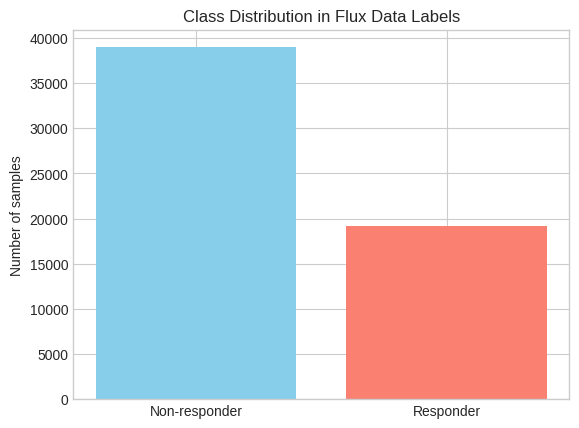

In [ ]:
unique, counts = np.unique(y_flux, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution in y_flux:", class_distribution)

plt.bar(class_distribution.keys(), class_distribution.values(), color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Non-responder', 'Responder'])
plt.ylabel('Number of samples')
plt.title('Class Distribution in Flux Data Labels')
plt.show()

### Step 6: Train-test split and feature scaling
We split the dataset into training and testing sets (80/20), stratified by response to maintain the same class ratio.  
Then we scale features to zero mean and unit variance using `StandardScaler`.  
The scaler is fit on the training set only, and then applied to both training and test sets to avoid data leakage.

In [ ]:
# Final input features and labels
X_final = X_flux_var
y_final = y_flux

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,
    stratify=y_final,
    random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train class balance:\n", pd.Series(y_train).value_counts(normalize=True))
print("Test class balance:\n", pd.Series(y_test).value_counts(normalize=True))

# Scale features (fit on train only)
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled = scaler_final.transform(X_test)

Train shape: (46541, 257), Test shape: (11636, 257)
Train class balance:
 response
0    0.669947
1    0.330053
Name: proportion, dtype: float64
Test class balance:
 response
0    0.66999
1    0.33001
Name: proportion, dtype: float64



Step 7: Top 100 Fluxomics Feature Selection

Feature Name Recovery – Retrieved column names retained after variance thresholding using the VarianceThreshold selector.

Random Forest Ranking – Trained a balanced RandomForestClassifier on the scaled training data to estimate feature importances.

Top 100 Selection – Chose the 100 most important fluxomic features based on importance scores.

Dataset Filtering – Reduced both training and test datasets to these top 100 features for downstream modeling.

Result: Training set reduced to 46,541 × 100 and test set to 11,636 × 100.


In [ ]:
# 1. Get feature names after variance thresholding
selected_features = X_flux.columns[selector.get_support()]

# 2. Train Random Forest on scaled data to rank features
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# 3. Extract top 100 feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:100]

# 4. Get top 100 feature names
top100_features = selected_features[indices]

# 5. Convert scaled NumPy arrays back to DataFrames to filter columns
X_train_df = pd.DataFrame(X_train_scaled, columns=selected_features)
X_test_df = pd.DataFrame(X_test_scaled, columns=selected_features)

# 6. Filter train and test to top 100 features
X_train_top100 = X_train_df[top100_features]
X_test_top100 = X_test_df[top100_features]

print(f"X_train shape after top 100 feature selection: {X_train_top100.shape}")
print(f"X_test shape after top 100 feature selection: {X_test_top100.shape}")


X_train shape after top 100 feature selection: (46541, 100)
X_test shape after top 100 feature selection: (11636, 100)


____
Logistic Regression with Class Imbalance Handling
Trained a logistic regression model with manual class weights and evaluated performance using accuracy, precision, recall, F1-score, ROC AUC, and a confusion matrix.
____

# **Logistic Regression**

Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2'}

[Responder Class Metrics]
Accuracy     : 47.61
Precision    : 31.87
Recall       : 51.64
F1 Score     : 39.42
ROC AUC Score: 48.00

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.66      0.46      0.54      7796
    Responder       0.32      0.52      0.39      3840

     accuracy                           0.48     11636
    macro avg       0.49      0.49      0.47     11636
 weighted avg       0.55      0.48      0.49     11636



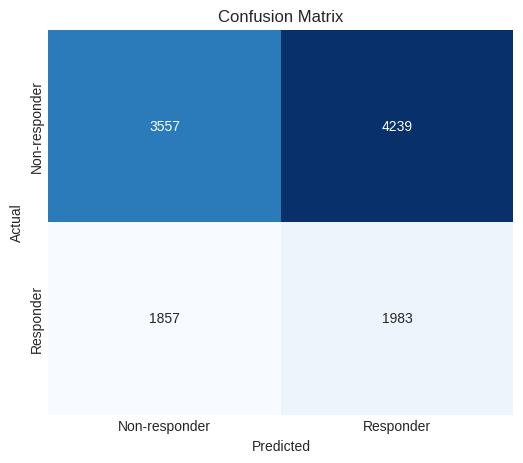

In [ ]:
# Step 1: Define pipeline (scaling + logistic regression)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Parameter grid for GridSearch
param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

# Step 3: Run GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Step 4: Best model
logreg = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Step 5: Predictions
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred_thresh = logreg.predict(X_test)   # default 0.5 threshold

# Step 6: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_thresh)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
accuracy = accuracy_score(y_test, y_pred_thresh)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 7: Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh, target_names=["Non-responder", "Responder"]))

# Step 8: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

____
XGBoost with Class Imbalance Handling
Trained an XGBoost classifier using scale_pos_weight to address class imbalance and evaluated performance using accuracy, precision, recall, F1-score, ROC AUC, and a confusion matrix.
____

____
XGBoost Feature Importance Visualization
Ranked features by importance scores from the trained XGBoost model and plotted the top 20 most influential fluxomic features.
____

# **XGBoost**

scale_pos_weight: 2.03
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:29:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 200}

[Responder Class Metrics]
Accuracy     : 48.56
Precision    : 30.14
Recall       : 42.40
F1 Score     : 35.23
ROC AUC Score: 45.87

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.65      0.52      0.57      7796
    Responder       0.30      0.42      0.35      3840

     accuracy                           0.49     11636
    macro avg       0.47      0.47      0.46     11636
 weighted avg       0.53      0.49      0.50     11636



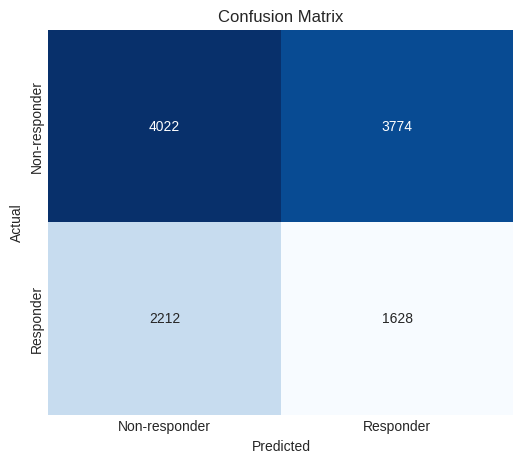

In [ ]:
# Step 1: Compute scale_pos_weight
neg = (y_train == 0).sum()  # Non-responders
pos = (y_train == 1).sum()  # Responders
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Step 2: Define pipeline (XGBoost only, no scaler)
pipe_xgb = Pipeline([
    ('model', XGBClassifier(
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        scale_pos_weight=scale_pos_weight
    ))
])

# Step 3: Parameter grid (user-specified)
param_xgb = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [200, 400, 800]
}

# Step 4: GridSearchCV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_xgb,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_xgb.fit(X_train, y_train)

# Step 5: Best model
xgb_model = grid_xgb.best_estimator_
print("Best Parameters:", grid_xgb.best_params_)

# Step 6: Predictions
y_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)   # default 0.5 threshold

# Step 7: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

# Step 8: Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

# Step 9: Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Feature Importance**

/tmp/ipython-input-2427492487.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


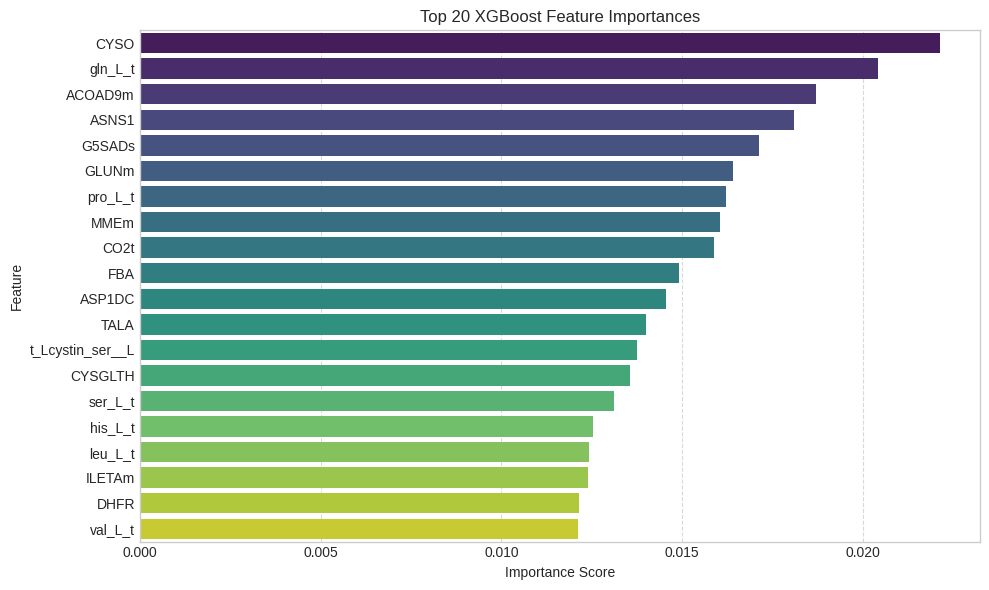

In [ ]:
# Step 1: Get feature names from your training DataFrame
feature_names = X_train_df.columns.tolist()

# Step 2: Get feature importances from the trained XGBoost pipeline model
importances = xgb_model.named_steps['model'].feature_importances_
sorted_idx = importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Step 3: Select top N features
top_n = 20
top_features = sorted_features[:top_n]
top_importances = sorted_importances[:top_n]

# Step 4: Plot top feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title(f"Top {top_n} XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--', alpha=0.3, color='gray')
plt.tight_layout()
plt.show()

____
Train a Random Forest classifier on the training data, predict responders, evaluate performance metrics, and visualize the confusion matrix.
____

# **Random Forest**

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'model__min_samples_leaf': 50}

[Responder Class Metrics]
Accuracy     : 48.96
Precision    : 29.94
Recall       : 40.78
F1 Score     : 34.53
ROC AUC Score: 45.67

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.53      0.58      7796
           1       0.30      0.41      0.35      3840

    accuracy                           0.49     11636
   macro avg       0.47      0.47      0.46     11636
weighted avg       0.53      0.49      0.50     11636



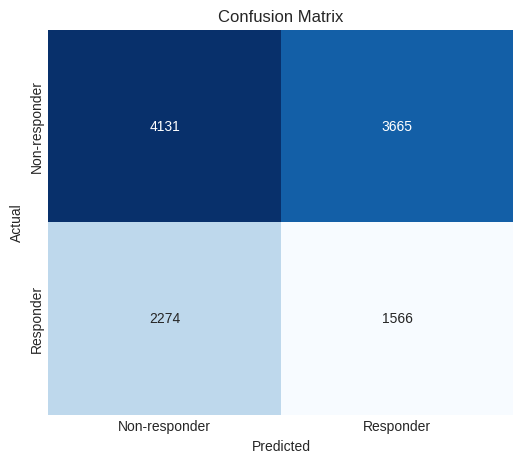

In [ ]:
# Step 1: Define pipeline (RF only, no scaler needed)
pipe_rf = Pipeline([
    ('model', RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        max_depth=8,
        min_samples_split=100,
        class_weight='balanced',
        random_state=42
    ))
])

# Step 2: Parameter grid
param_rf = {
    'model__min_samples_leaf': [50, 100]
}

# Step 3: GridSearchCV with 3-fold CV
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_rf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Step 4: Fit GridSearchCV
grid_rf.fit(X_train, y_train)

# Step 5: Best model
rf_model = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

# Step 6: Predictions (with prob + threshold style)
y_prob = rf_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_thresh = (y_prob > threshold).astype(int)

# Step 7: Evaluation metrics
conf_mat = confusion_matrix(y_test, y_pred_thresh)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
accuracy = accuracy_score(y_test, y_pred_thresh)

# Step 8: Print metrics
print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

# Step 9: Confusion Matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-responder", "Responder"],
    yticklabels=["Non-responder", "Responder"],
    cbar=False,
    linewidths=0,
    linecolor="white"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

____
Train a feedforward ANN on scaled fluxomic data, predict responders, evaluate performance metrics, and plot the confusion matrix.
____

# **Artificial Neural Network**

In [ ]:
# ------------------------------
# Imports
# ------------------------------
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    confusion_matrix
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ------------------------------
# Reproducibility setup
# ------------------------------
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ------------------------------
# Step 1: Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# Step 2: Define ANN
# ------------------------------
ann_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# ------------------------------
# Step 3: Compile
# ------------------------------
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ------------------------------
# Step 4: Compute class weights
# ------------------------------
classes = np.unique(y_train)
class_weights_values = compute_class_weight(
    class_weight='balanced', classes=classes, y=y_train
)
class_weight_dict = dict(zip(classes, class_weights_values))
print(f"Using class weights: {class_weight_dict}")

# ------------------------------
# Step 5: Early stopping
# ------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ------------------------------
# Step 6: Train
# ------------------------------
history = ann_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    shuffle=True,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Using class weights: {np.int64(0): np.float64(0.7463277742142399), np.int64(1): np.float64(1.514907883601328)}
Epoch 1/50
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5015 - loss: 0.8064 - val_accuracy: 0.4370 - val_loss: 0.6972
Epoch 2/50
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4895 - loss: 0.6942 - val_accuracy: 0.4056 - val_loss: 0.6957
Epoch 3/50
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4958 - loss: 0.6933 - val_accuracy: 0.4358 - val_loss: 0.6967
Epoch 4/50
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4916 - loss: 0.6935 - val_accuracy: 0.4600 - val_loss: 0.6958
Epoch 5/50
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4896 - loss: 0.6934 - val_accuracy: 0.4137 - val_loss: 0.6970


364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

[Responder Class Metrics]
Accuracy     : 40.56
Precision    : 33.09
Recall       : 78.41
F1 Score     : 46.54
ROC AUC Score: 50.26

Classification Report (Test Data):
               precision    recall  f1-score   support

Non-responder       0.67      0.22      0.33      7796
    Responder       0.33      0.78      0.47      3840

     accuracy                           0.41     11636
    macro avg       0.50      0.50      0.40     11636
 weighted avg       0.56      0.41      0.38     11636



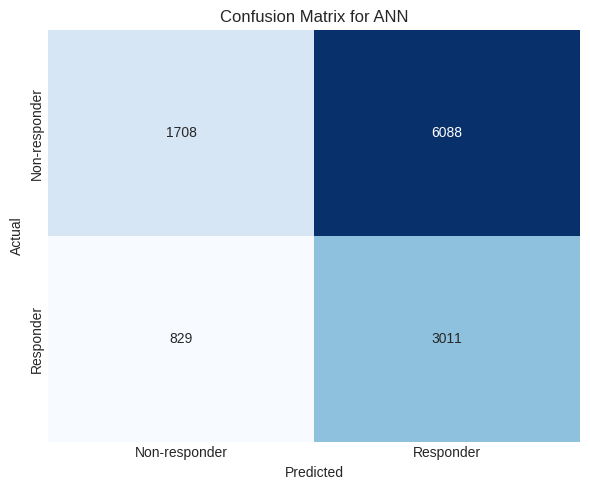

In [ ]:
# ================================================================
# Step 7: Predictions
# ================================================================
y_prob = ann_model.predict(X_test_scaled).flatten()
y_pred = (y_prob > 0.5).astype(int)

# ================================================================
# Step 8: Evaluation metrics
# ================================================================
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}\n")

print("Classification Report (Test Data):")
print(classification_report(
    y_test, y_pred,
    target_names=['Non-responder', 'Responder']
))

# ================================================================
# Step 9: Confusion matrix plot
# ================================================================
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False,
    linewidths=0,
    linecolor='white'
)
plt.title("Confusion Matrix for ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

____
Compare the predictive performance of all models by plotting their ROC curves and reporting AUC scores on the test data.
____

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


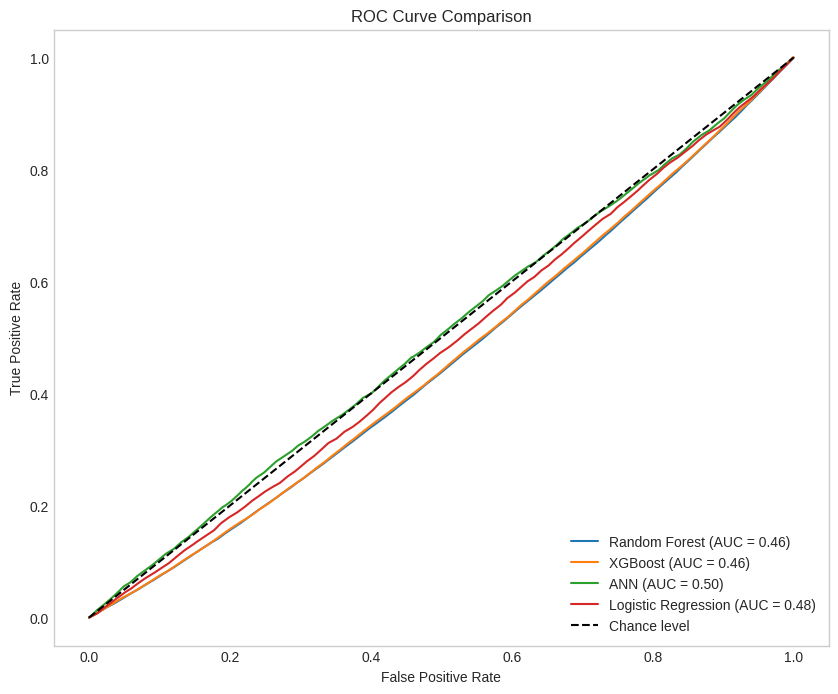

In [ ]:
X_test_np = X_test

# Get prediction probabilities from each model
y_prob_rf = rf_model.predict_proba(X_test_np)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test_np)[:, 1]
y_prob_ann = ann_model.predict(X_test_np).ravel()
y_prob_lr = logreg.predict_proba(X_test_np)[:, 1]

# Compute ROC curve and AUC for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curves together
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc_ann:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance level')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()

____
Plot calibration curves for all models to assess how well predicted probabilities match the true responder rates.
____

# **Calibration plots**

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


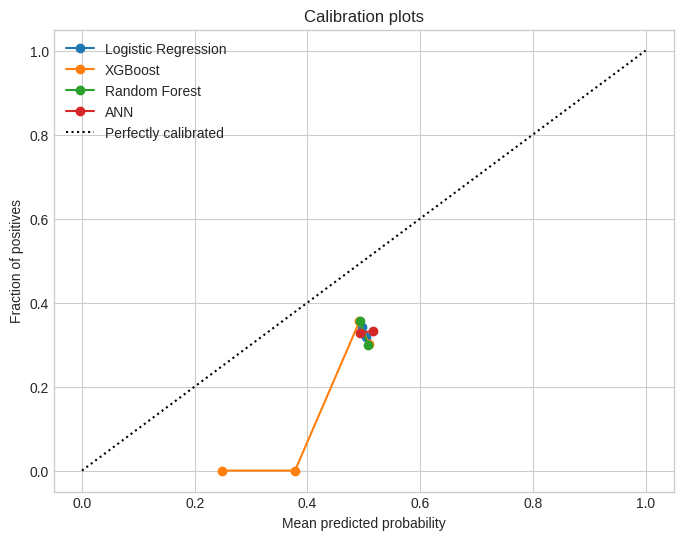

In [ ]:
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test_np)[:, 1]
y_prob_ann = ann_model.predict(X_test_np).ravel()
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

plt.figure(figsize=(8, 6))

for model_name, y_prob in [
    ('Logistic Regression', y_prob_lr),
    ('XGBoost', y_prob_xgb),
    ('Random Forest', y_prob_rf),
    ('ANN', y_prob_ann)
]:
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.grid(True)
plt.show()

____
Calculate Brier scores for all models to assess the accuracy of predicted probabilities.
Lower Brier scores indicate better calibrated predictions.
In this case, the ANN achieves the lowest Brier score (0.22), suggesting it predicts responder probabilities more reliably than Logistic Regression, XGBoost, or Random Forest (0.25 each).
____

# **Brier Scores**

In [ ]:
brier_logreg = brier_score_loss(y_test, y_prob_lr)
brier_xgb = brier_score_loss(y_test, y_prob_xgb)
brier_rf = brier_score_loss(y_test, y_prob_rf)
brier_ann = brier_score_loss(y_test, y_prob_ann)

print(f"Brier Score - Logistic Regression: {brier_logreg:.4f}")
print(f"Brier Score - XGBoost: {brier_xgb:.4f}")
print(f"Brier Score - Random Forest: {brier_rf:.4f}")
print(f"Brier Score - ANN: {brier_ann:.4f}")

Brier Score - Logistic Regression: 0.2502
Brier Score - XGBoost: 0.2507
Brier Score - Random Forest: 0.2506
Brier Score - ANN: 0.2512


____
Compute Matthews Correlation Coefficient (MCC) for all models to evaluate the quality of binary predictions.
MCC accounts for true and false positives and negatives, providing a balanced measure even for imbalanced classes.
In this case, all models show very low MCC values (~0 to 0.01), indicating limited predictive power for distinguishing responders from non-responders.
____

# **MCC**

In [ ]:
threshold = 0.5

# Predict probabilities for each model
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_ann = ann_model.predict(X_test_np).ravel()

y_pred_logreg = (y_prob_logreg > threshold).astype(int)
y_pred_xgb = (y_prob_xgb > threshold).astype(int)
y_pred_rf = (y_prob_rf > threshold).astype(int)
y_pred_ann = (y_prob_ann > threshold).astype(int)

# Calculate MCC scores
mcc_logreg = matthews_corrcoef(y_test, y_pred_logreg)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)
mcc_ann = matthews_corrcoef(y_test, y_pred_ann)

print(f"MCC - Logistic Regression: {mcc_logreg:.4f}")
print(f"MCC - XGBoost: {mcc_xgb:.4f}")
print(f"MCC - Random Forest: {mcc_rf:.4f}")
print(f"MCC - ANN: {mcc_ann:.4f}")


364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MCC - Logistic Regression: -0.0258
MCC - XGBoost: -0.0567
MCC - Random Forest: -0.0589
MCC - ANN: 0.0036


# **XGBoost retrained for SHAP interpretability**

scale_pos_weight: 2.03


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:43:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

[Responder Class Metrics]
Accuracy     : 47.33
Precision    : 31.33
Recall       : 50.03
F1 Score     : 38.53
ROC AUC Score: 47.15

Classification Report:
               precision    recall  f1-score   support

Non-responder       0.65      0.46      0.54      7796
    Responder       0.31      0.50      0.39      3840

     accuracy                           0.47     11636
    macro avg       0.48      0.48      0.46     11636
 weighted avg       0.54      0.47      0.49     11636



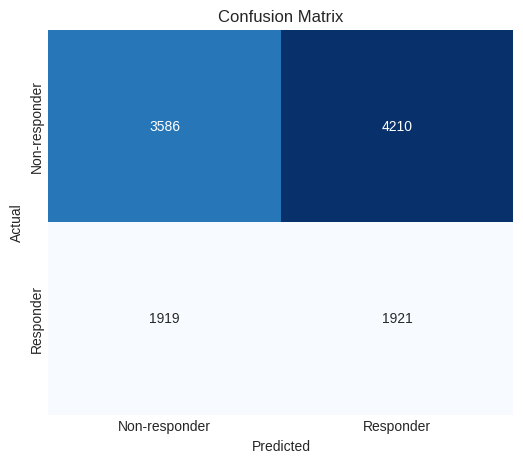

In [ ]:
# Step 1: Compute scale_pos_weight for imbalance handling
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Step 2: Define base model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Step 3: Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 4: GridSearchCV
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)

# Step 5: Best model
xgb_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Step 6: Predictions
y_prob = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

# Step 7: Metrics
conf_mat = confusion_matrix(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n[Responder Class Metrics]")
print(f"Accuracy     : {accuracy * 100:.2f}")
print(f"Precision    : {precision * 100:.2f}")
print(f"Recall       : {recall * 100:.2f}")
print(f"F1 Score     : {f1 * 100:.2f}")
print(f"ROC AUC Score: {roc * 100:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-responder", "Responder"]))

# Step 8: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-responder', 'Responder'],
    yticklabels=['Non-responder', 'Responder'],
    cbar=False
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **SHAP**

/tmp/ipython-input-3856918938.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_full, plot_type="bar", max_display=10)


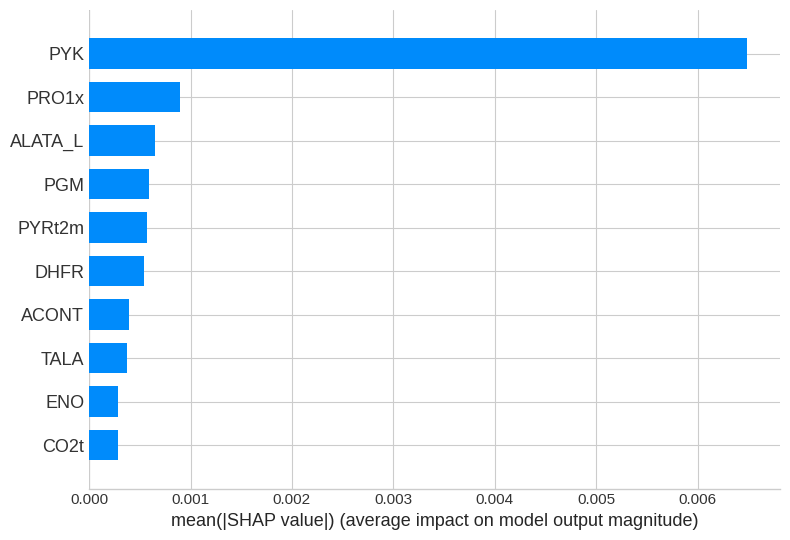

/tmp/ipython-input-3856918938.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_full, max_display=10)


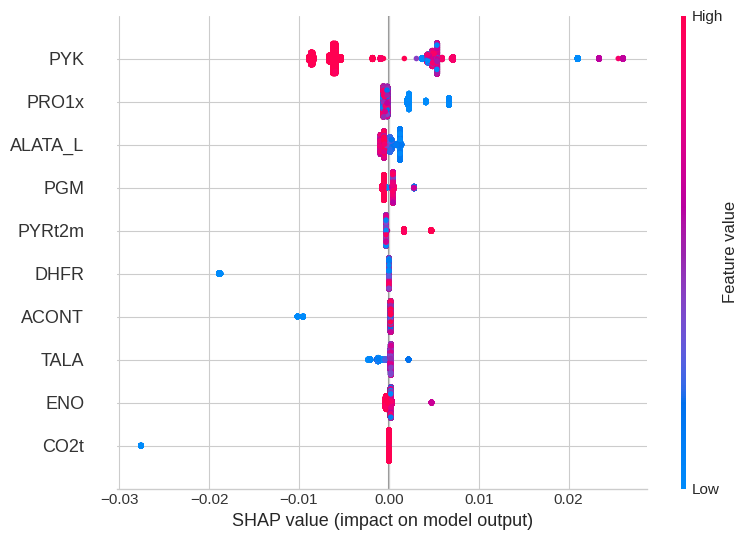

In [ ]:
# Step 1: Create TreeExplainer
explainer = shap.TreeExplainer(xgb_model)

# Step 2: Use the full test set
X_full = X_test

# Step 3: Compute SHAP values
shap_values = explainer.shap_values(X_full)

# Step 4: Summary plot (top 10 features only)
shap.summary_plot(shap_values, X_full, plot_type="bar", max_display=10)

# Optional: Detailed beeswarm plot (top 10 features only)
shap.summary_plot(shap_values, X_full, max_display=10)